In [1]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from utils import *
import pickle

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [4]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,3.475753e+03,2.813504e+03,6.284778e+03,1.975985,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,1.054549e+02,54.541936,22.216197,1167.560257,1.975559e+04,5.381859e+02,3.519654e+02,17.805741,1178.124581,2.144121e+04,4.416836e+02,2.990518e+02,8.931155e+05,5.733389e+06,8.904876e+06,1.332912e+06,1.162227e+06,2.537420e+04,4.618173e+06,6.764059e+06,4.246261e+05,1.293048e+06,8.930607e+05,6.085861e+06,1.011627e+07,1.260414e+06,8.197949e+05,8.433863e+04,10.925990,11.081897,1159.948376,1.210176e+04,9.029155e+01,4.742144e+03,0.043071,1.864668,6.219484e+03,4.148455e+06,8.041311e+05,1.059131e+06,1.148116e+06,8.946945e+05,1.179072e+05,4.571039e+06,5.764442e+06,8.678673e+06,5.109868e+06,6.037600e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,1.696581e+05,1.579508e+05,3.246767e+05,31.937681,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,3.639657e+03,351.378688,43.025812,2464.742493,3.385688e+05,1.639081e+04,2.860092e+03,32.883272,2464.226347,3.469619e+05,1.280389e+04,4.456432e+03,6.836720e+07,2.356495e+08,2.966493e+08,9.935204e+07,6.019453e+07,1.451423e+06,2.256559e+08,1.885185e+08,2.769771e+07,1.059583e+08,6.836746e+07,3.022425e+08,7.036060e+08,1.011819e+08,3.227715e+07,5.690312e+06,73.305702,80.394173,14522.031819,1.

In [5]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

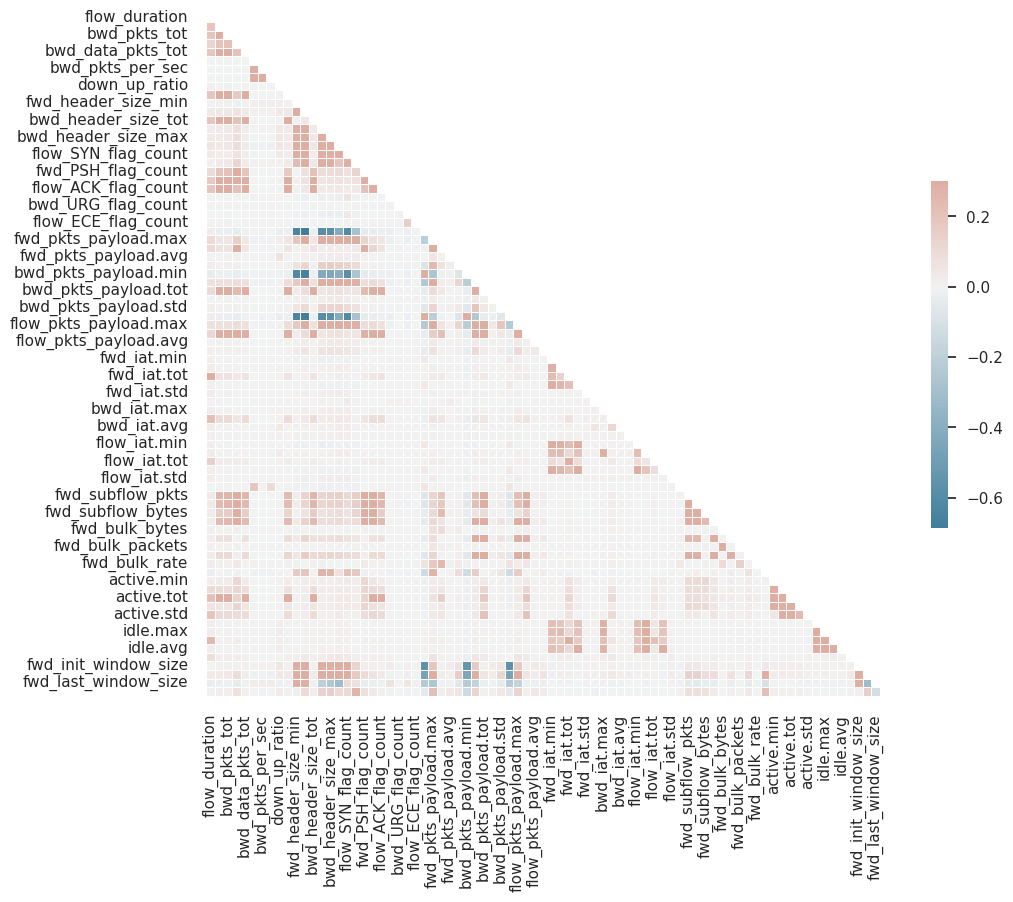

In [6]:

show_corr_matrix(ds)

In [7]:

compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


gbtree was choosen over dart because is faster and over the linear one because the linear one poorly perform

In [17]:
params = {
    "n_estimators": 6, 
    "max_depth": 4, 
    "learning_rate": 1, 
    "booster": 'gbtree', 
    "objective": 'binary:logistic',
    "n_jobs": -1,
    "random_state": 12
}

In [18]:
bst = XGBClassifier(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, XGBClassifier, params)

In [19]:
X_res, y_res = pv.get_undersampled_ds()
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=y_res)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

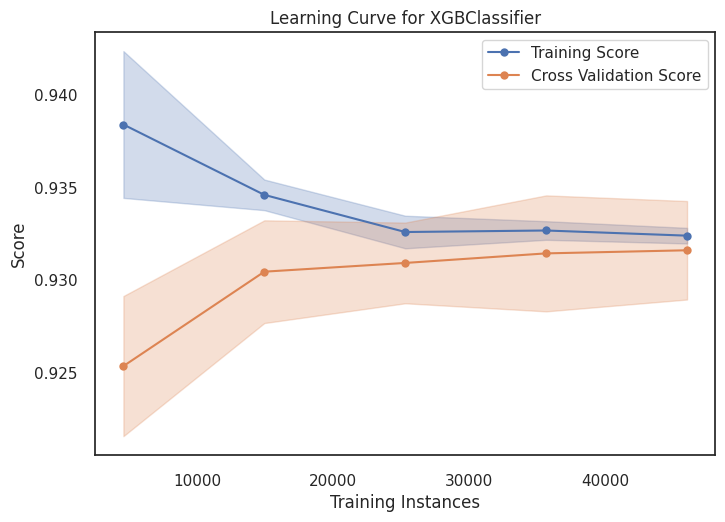

In [11]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=bst, cv=cv, scoring='f1', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="bst_data/learning_curve.png")

![Alt text](bst_data/learning_curve.png)

In [20]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 50.9 s, sys: 92.3 ms, total: 51 s
Wall time: 23 s


(0.9316990797814817, 0.0018337176704194883, 4.073405504226685)

In [22]:
%time bst.fit(X_train, y_train)

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 326 ms


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=6, n_jobs=-1,
              num_parallel_tree=None, random_state=12, ...)

In [23]:
%time y_predicted_train = bst.predict(X_train)
%time y_predicted_test = bst.predict(X_test)

CPU times: user 417 ms, sys: 0 ns, total: 417 ms
Wall time: 62.1 ms
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 24.1 ms


In [24]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.928545,0.928488
1,PRECISION,0.876892,0.876633
2,RECALL,0.997066,0.997340
3,F1 SCORE,0.933126,0.933099
4,AUC,0.928546,0.928482


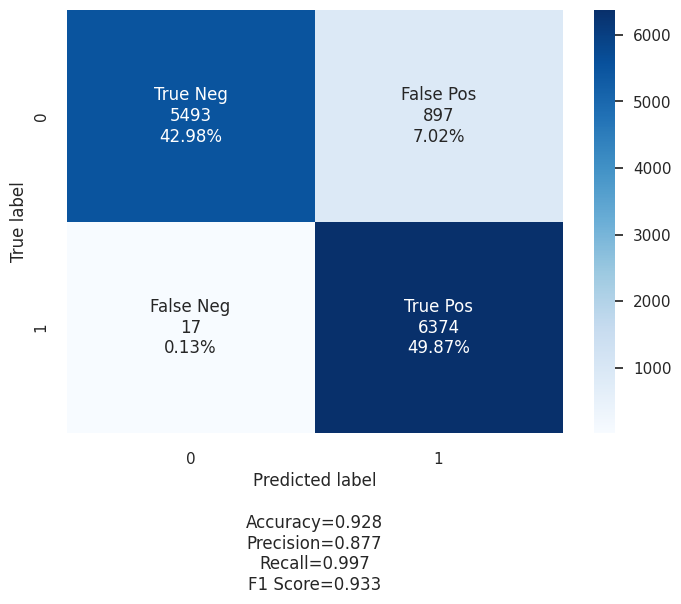

In [25]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [26]:
import xgboost as xgb

for tree_num in range(0,6):
    tree_viz = xgb.to_graphviz(bst, num_trees=0, rankdir='LR')
    tree_viz.render(f"bst_data/tree_{tree_num}")

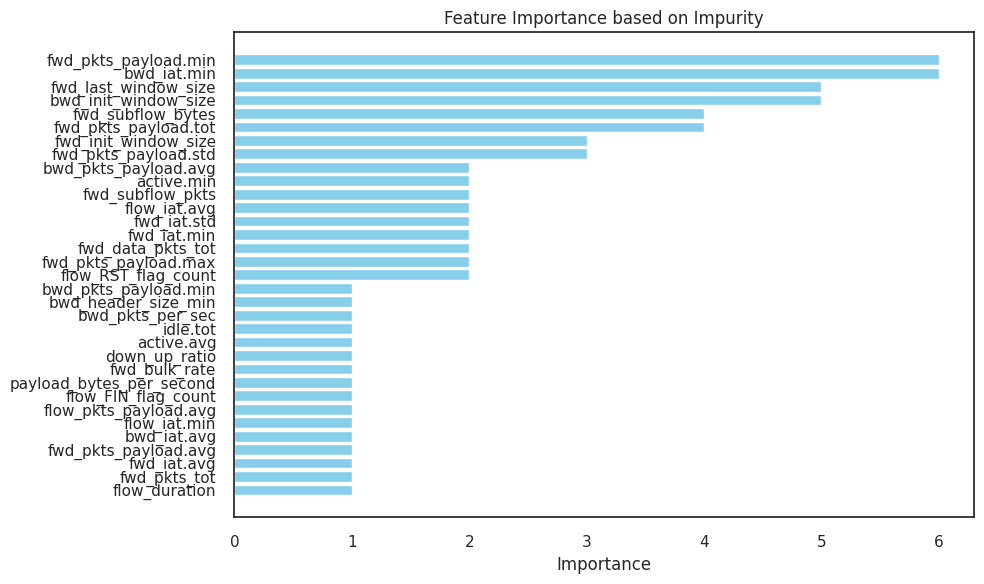

In [27]:
# Get feature importance based on impurity
impurity_importance = bst.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a DataFrame
feature_importance_df = pd.DataFrame(list(impurity_importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Reset index
feature_importance_df.reset_index(drop=True, inplace=True)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance based on Impurity')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

In [28]:
%%time

explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
sv = explainer.shap_values(X_train)

exp = Explanation(sv, 
                  np.mean(bst.predict(X_train)), 
                  data=X_train.values, 
                  feature_names=x_features)

[15:25:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


CPU times: user 4.37 s, sys: 0 ns, total: 4.37 s
Wall time: 4.26 s


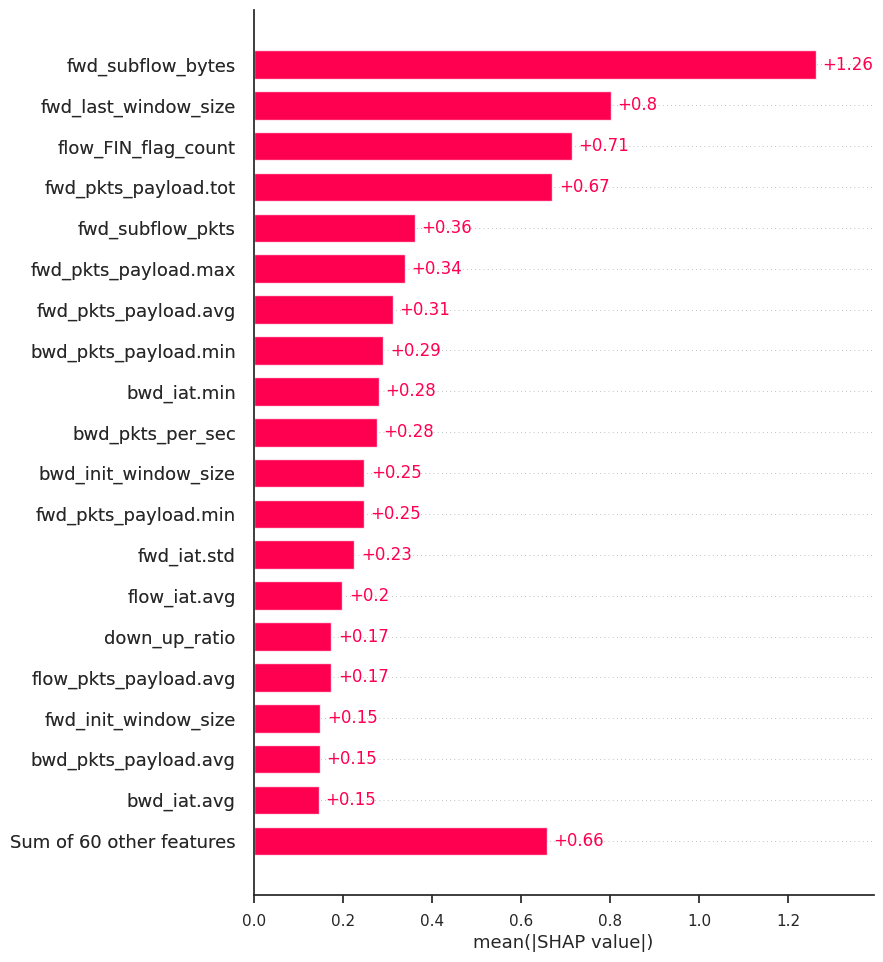

In [29]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

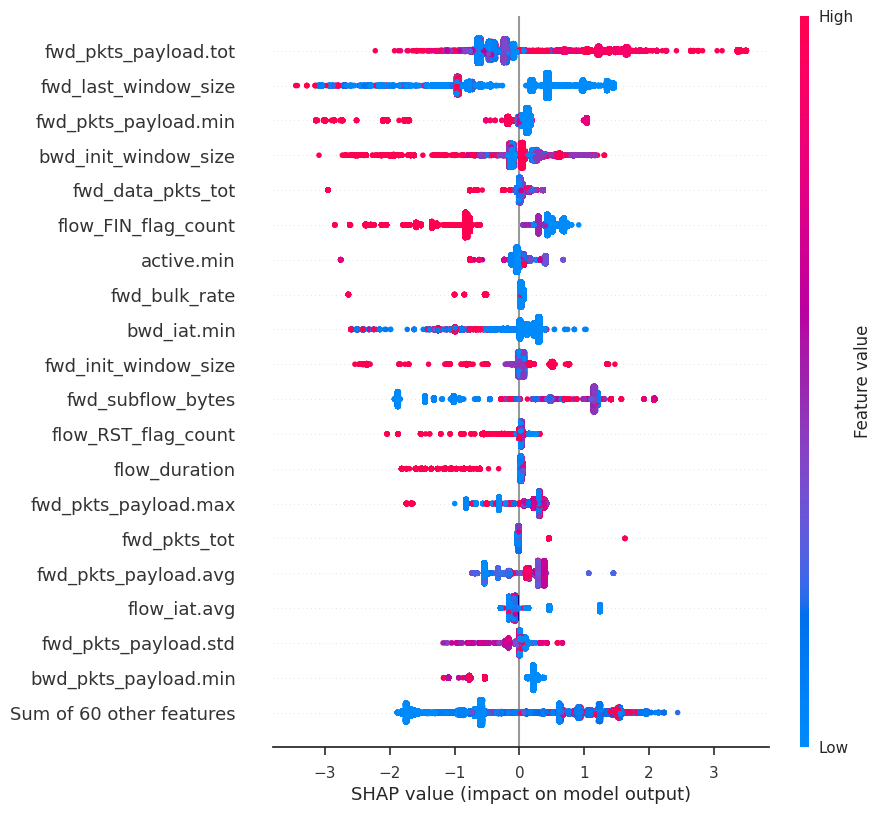

In [30]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [31]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,1.262789,fwd_subflow_bytes
78,0.801334,fwd_last_window_size
15,0.714142,flow_FIN_flag_count
27,0.670231,fwd_pkts_payload.tot
56,0.361370,fwd_subflow_pkts
26,0.339529,fwd_pkts_payload.max
28,0.313042,fwd_pkts_payload.avg
30,0.291170,bwd_pkts_payload.min
45,0.281287,bwd_iat.min
6,0.277072,bwd_pkts_per_sec


In [32]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [33]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('abc_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 33 features
Running the cross validation
testing with 32 features
Running the cross validation
testing with 31 features
Running the cross validation
testing with 30 features
Running the cross validation
testing with 29 features
Running the cross validation
testing with 28 features
Running the cross validation
testing with 27 features
Running the cross validation
testing with 26 features
Running the cross validation
testing with 25 features
Running the cross validation
testing with 24 features
Running the cross validation
testing with 23 features
Running the cross validation
testing with 22 features
Running the cross validation
testing with 21 features
Running the cross validation
testing with 20 features
Running the cross validation
testing with 19 features
Running the cross validation
testing with 18 features
Running the cross validation
testing with 17 features
Running the cross validation
testing with 16 features
Running the cross validation

<Axes: xlabel='n_features', ylabel='cv_time'>

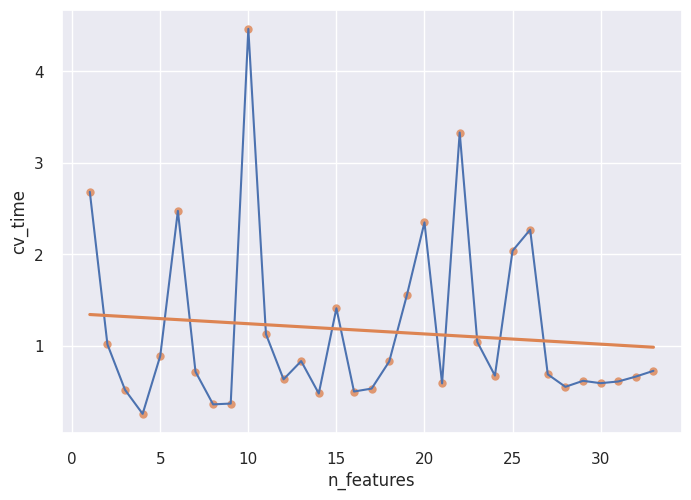

In [34]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

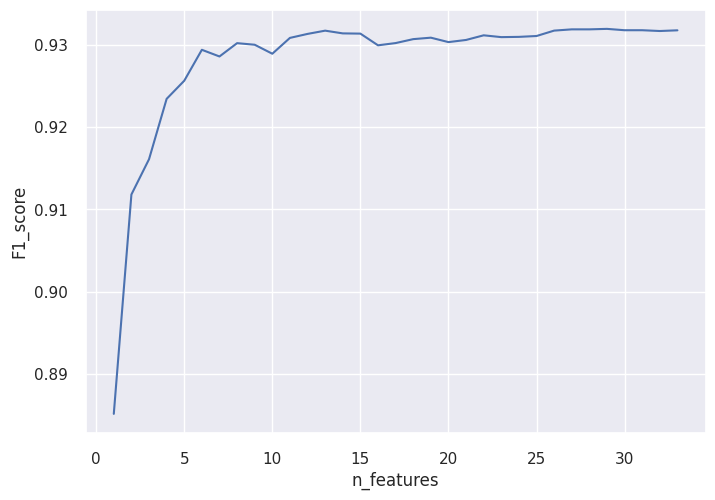

In [35]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

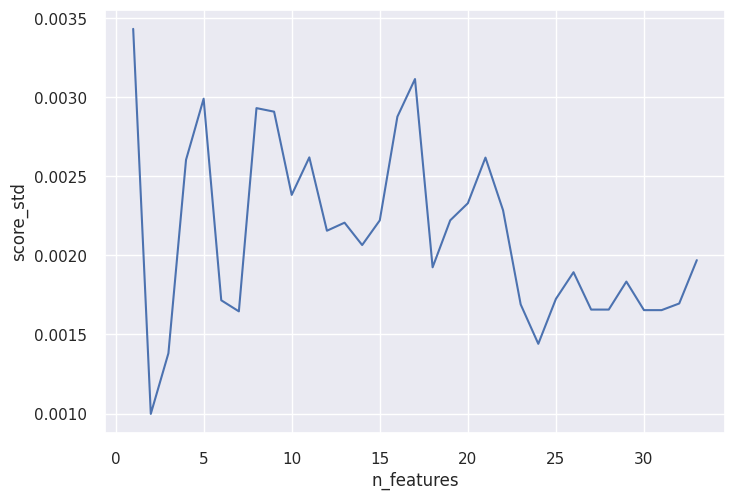

In [36]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [37]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
4,0.931942,0.001834,29,0.616938
5,0.931884,0.001657,28,0.551527
6,0.931884,0.001657,27,0.687980
2,0.931778,0.001654,31,0.609751
3,0.931778,0.001654,30,0.591258
0,0.931767,0.001970,33,0.726231
7,0.931731,0.001894,26,2.269030
20,0.931725,0.002207,13,0.832369
1,0.931682,0.001696,32,0.663352
19,0.931393,0.002065,14,0.478505


In [38]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 33 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 32 features
Running the cross validation
training with 31 features
Running the cross validation
training with 30 features
Running the cross validation
training with 29 features
Running the cross validation
training with 28 features
Running the cross validation
training with 27 features
Running the cross validation
training with 26 features
Running the cross validation
training with 25 features
Running the cross validation
training with 24 features
Running the cross validation
training with 23 features
Running the cross validation
training with 22 features
Running the cross validation
training with 21 features
Running the cross validation
training with 20 features
Running the cross validation
training with 19 features
Running the cross validation
training with 18 features
Running the cross validation
training with 17 features
Ru

Here we can have zero on the results of f1 and recall that means that the model has failed to detect the attack, while the cross validation result is usefull only to see how well the model is scoring with all the data except the one regarding the attack

In [39]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [40]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
129,0.920503,0.998748,0.853627,0.910079,0.003140,3,Bruteforce-XML,0.062708,0.010210,1
127,0.430384,0.312093,0.693078,0.927483,0.002749,5,Bruteforce-XML,0.021825,0.002605,1
98,0.299641,0.203931,0.564645,0.901105,0.005897,1,Bruteforce,0.019888,0.008361,1
97,0.190093,0.121307,0.439058,0.919609,0.005626,2,Bruteforce,0.014607,0.002032,1
128,0.174746,0.109664,0.429833,0.922810,0.003744,4,Bruteforce-XML,0.015992,0.002146,1
...,...,...,...,...,...,...,...,...,...,...
123,0.000220,0.000125,0.000923,0.931727,0.002222,9,Bruteforce-XML,0.029185,0.002941,1
124,0.000220,0.000125,0.000921,0.932909,0.002254,8,Bruteforce-XML,0.020872,0.002537,1
126,0.000220,0.000125,0.000920,0.932481,0.003560,6,Bruteforce-XML,0.016352,0.001939,1
32,0.000225,0.000125,0.001112,0.922132,0.002793,1,XMRIGCC CryptoMiner,0.015463,0.001866,1


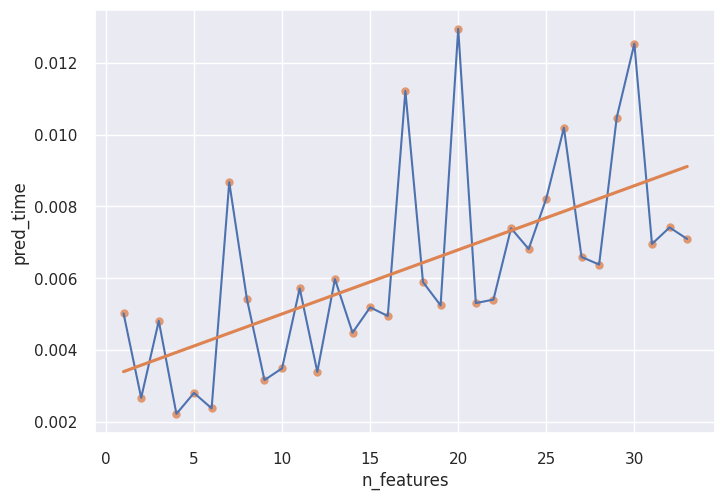

In [41]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

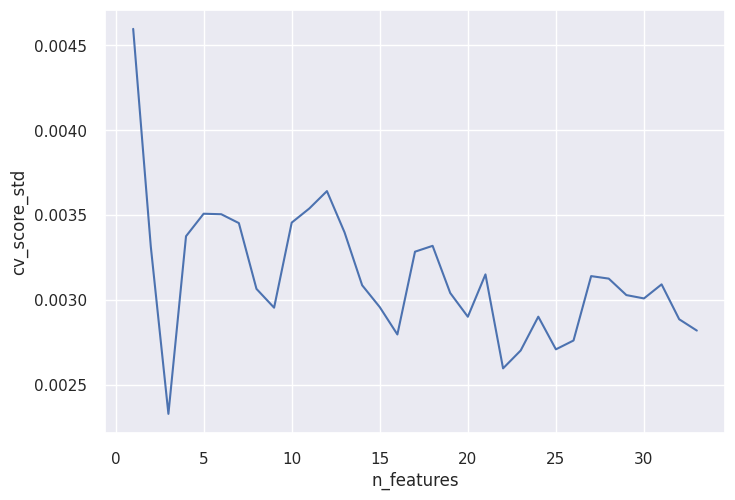

In [42]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [43]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
3,0.262274,0.268872,0.317323,0.930969,0.002327,0.029955,0.004807,1.00
5,0.121474,0.086098,0.223906,0.942183,0.003507,0.018660,0.002801,0.75
2,0.094341,0.059965,0.229234,0.928991,0.003314,0.019547,0.002664,1.00
1,0.087824,0.058400,0.191344,0.899881,0.004597,0.036117,0.005016,1.00
4,0.083165,0.051515,0.219920,0.941652,0.003375,0.016814,0.002217,0.75
14,0.054026,0.032705,0.160317,0.947973,0.003085,0.030199,0.004480,0.75
12,0.052390,0.032111,0.147477,0.947483,0.003641,0.056903,0.003388,0.75
13,0.047376,0.028793,0.137990,0.947898,0.003397,0.032690,0.005973,0.75
25,0.044291,0.027197,0.121334,0.948043,0.002707,0.053393,0.008219,0.75


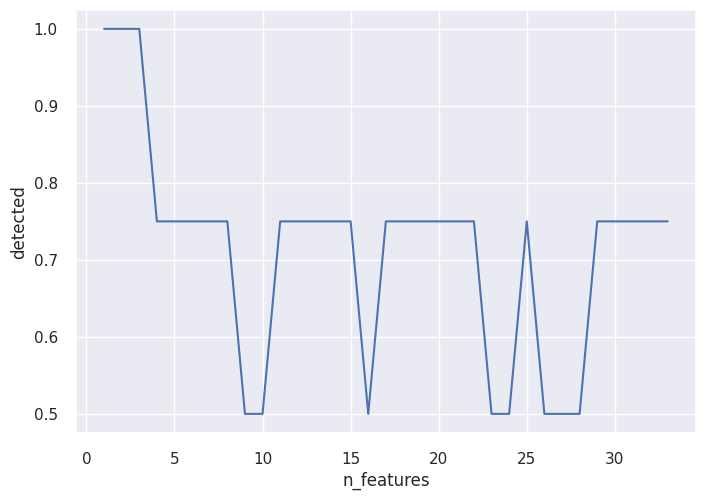

In [44]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

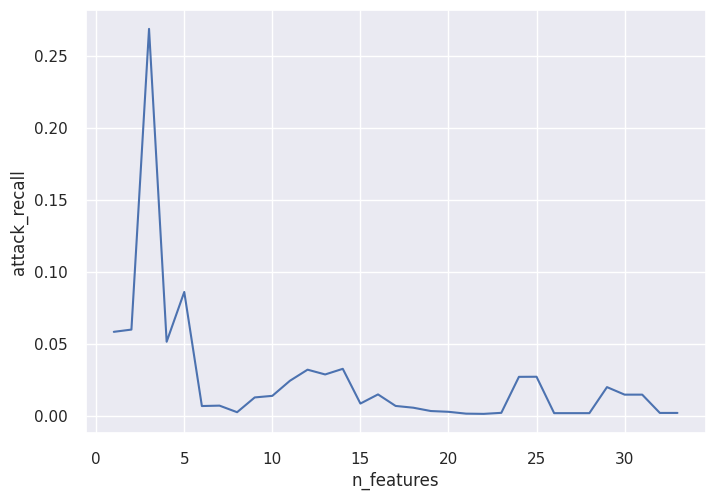

In [45]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [46]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
3,0.262274,0.268872,0.317323,0.930969,0.002327,0.029955,0.004807
5,0.121474,0.086098,0.223906,0.942183,0.003507,0.018660,0.002801
2,0.094341,0.059965,0.229234,0.928991,0.003314,0.019547,0.002664
1,0.087824,0.058400,0.191344,0.899881,0.004597,0.036117,0.005016
4,0.083165,0.051515,0.219920,0.941652,0.003375,0.016814,0.002217
14,0.054026,0.032705,0.160317,0.947973,0.003085,0.030199,0.004480
12,0.052390,0.032111,0.147477,0.947483,0.003641,0.056903,0.003388
13,0.047376,0.028793,0.137990,0.947898,0.003397,0.032690,0.005973
25,0.044291,0.027197,0.121334,0.948043,0.002707,0.053393,0.008219


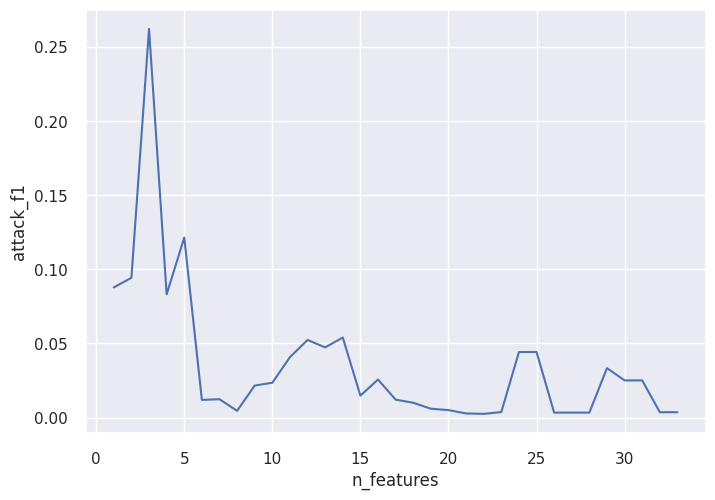

In [47]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [48]:
zero_day_feature_reduction_scores.query('n_features == 3')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
30,0.006401,0.003505,0.036842,0.953793,0.001572,3,XMRIGCC CryptoMiner,0.016830,0.002486,1
63,0.009949,0.005508,0.051342,0.933389,0.002439,3,Probing,0.021409,0.003904,1
96,0.112241,0.067727,0.327482,0.926614,0.002156,3,Bruteforce,0.018871,0.002628,1
129,0.920503,0.998748,0.853627,0.910079,0.003140,3,Bruteforce-XML,0.062708,0.010210,1


In [49]:
zero_day_feature_reduction_scores.query('n_features == 5')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
28,0.000000,0.000000,0.000000,0.964320,0.001646,5,XMRIGCC CryptoMiner,0.015762,0.003744,0
61,0.007925,0.004382,0.041420,0.946045,0.006111,5,Probing,0.020039,0.002432,1
94,0.047589,0.027917,0.161127,0.930885,0.003522,5,Bruteforce,0.017015,0.002422,1
127,0.430384,0.312093,0.693078,0.927483,0.002749,5,Bruteforce-XML,0.021825,0.002605,1
